In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
from matplotlib.lines import Line2D
from matplotlib.markers import MarkerStyle
import pandas as pd
import os
import glob
from mpl_toolkits.mplot3d import Axes3D
import re

# Equations

In [4]:
def R_inv(A_cont, A_I):
    return np.sqrt((1 - ((2 * A_cont)/A_I - 1)**2)/A_cont)/2

def dR_invdAI(A_cont, A_I):
    return - (A_I - 2 * A_cont)/(A_I**2 * np.sqrt(A_I - A_cont))/2

def dR_invdA_cont(A_cont, A_I):
    return - 1 / (2 * A_I * np.sqrt(A_I - A_cont))

def line_tension(A_cont, z):
    return z*np.sqrt(np.pi)/np.sqrt(A_cont)

# Dynamical equations
def A_I_dot(A_I, A_cont, k, z, C0):
    def bending_term(Ai):
        return (R_inv(A_cont, Ai) - C0)**2 + 2 * Ai * (R_inv(A_cont, Ai) - C0) * dR_invdAI(A_cont, Ai)
    return - 2 * k * (bending_term(A_I)-bending_term((1-A_I)))

def A_cont_dot(A_I, A_cont, k, z, C0):
    def bending_term(Ai):
        return Ai * (R_inv(A_cont, Ai) - C0) * dR_invdA_cont(A_cont, Ai)
    
    return - (4 * k * (bending_term(A_I) + bending_term((1-A_I))) + line_tension(A_cont, z))

# Parameters and flow grid

In [5]:
kappa = 20
C0 = 0.4

A_I_vals = np.linspace(0, 1, 1000)
A_cont_vals = np.linspace(0, 0.5, 1000)

A_I_grid, A_cont_grid = np.meshgrid(A_I_vals, A_cont_vals)

# Masking invalid geometries
mask = (A_cont_grid > 0) & (A_cont_grid < A_I_grid) & (A_cont_grid < (1 - A_I_grid))


# Perfect sphere condition
sphere = A_I_vals - A_I_vals**2 # RuntimeWarning due to forbidden geometries (A_cont < 0 | A_cont > A_I | A_cont > A - A_I)

# Import bifurcation diagram and plot

In [6]:
# Folder path where the CSV files are stored
directory = r'C:\Users\lenovo\Documents\Masterarbeit\Programming\output\Bifurcations'

In [7]:
# Function to split branches at A_I=A_val/2
def split_side_branch(df):
    left_branch = df[df[0]<0.5]
    right_branch = df[df[0]>0.5]
    return left_branch, right_branch

# Function to split main branch at maximum zeta
def split_main_branch(df):
    max_index = df[2].idxmax()
    max_value = df.loc[max_index, 1]
    upper_branch = df[df[1]>=max_value]
    lower_branch = df[df[1]<max_value]
    return upper_branch, lower_branch

In [10]:
# Function to plot a plane in zeta dimension
def plot_plane_at_x(ax, x_value):
    # Create a meshgrid
    y = np.linspace(0, 1, 1000)
    z = np.linspace(0, 0.5, 1000)
    Y, Z = np.meshgrid(y, z)

    X = np.full_like(Y, x_value)

    # Plot the surface
    ax.plot_surface(X, Y, Z, color='gray', alpha=0.3, rstride=5, cstride=5)
    
# Function to plot branches in 3D
def plot_branch_3D(branch, ax, x_values=None):
    global bp_label_added, lp_label_added

    branch = branch[branch[2] > 0]
    
    # Stability for unstable FPs, saddles & stable FPs
    stability_styles = {0: ':', 1: '--', 2: '-'}
    
    for stability, linestyle in stability_styles.items():
        subset = branch[branch[3] == stability]
        ax.plot(subset[2].values, subset[0].values, subset[1].values, linestyle=linestyle, color='black', lw = 1, alpha=0.8)

    # Scatter points for BP and LP
    bp_points = branch[branch[3] == 3]
    lp_points = branch[(branch[3] == 4) & (branch[1]>0.01)] # Ignore "false" LPs
    
    if not bp_label_added:
        ax.scatter(bp_points[2].values, bp_points[0].values, bp_points[1].values, s=50, color=scatter_colorstyle["BP"], marker = 'd', edgecolor = 'black', label="Branching Point", zorder = 3)
        bp_label_added = True
    else:
        ax.scatter(bp_points[2].values, bp_points[0].values, bp_points[1].values, s=50, color=scatter_colorstyle["BP"], marker = 'd', edgecolor = 'black', zorder = 3)

    if not lp_label_added:
        ax.scatter(lp_points[2].values, lp_points[0].values, lp_points[1].values, s=50, color=scatter_colorstyle["LP"], marker = 'd', edgecolor = 'black', label="Limit Point", zorder = 3)
        lp_label_added = True
    else:
        ax.scatter(lp_points[2].values, lp_points[0].values, lp_points[1].values, s=50, color=scatter_colorstyle["LP"], marker = 'd', edgecolor = 'black', zorder = 3)
    
    # Plot FPs
    if x_values:
        for x_value in x_values:
            idx_closest = (branch[2] - x_value).abs().idxmin()
            FP = branch.loc[idx_closest]

            if FP[3] == 2:
                ax.scatter(FP[2], FP[0], FP[1], marker='o', c='black', s=40, zorder=3)
            elif FP[3] == 1:
                ax.scatter(FP[2], FP[0], FP[1], marker=MarkerStyle('o', fillstyle='right'), c='black', s=40, zorder=3)
                ax.scatter(FP[2], FP[0], FP[1], marker=MarkerStyle('o', fillstyle='left'), c='white', edgecolor='black', s=40, zorder=3)
            elif FP[3] == 0:
                ax.scatter(FP[2], FP[0], FP[1], marker='o', c='white', edgecolor='black', s=40, zorder=3)
        
        

# Function to plot branches in 2D
# Conditions necessary in order not to plot dashed lines on top of each other
def plot_branch_2D(branch, ax1, ax2, x_values = None, condition_cont = True, condition_I = True):
    global bp_label_added, lp_label_added
    
    branch = branch[branch[2] > 0]
    
    # Stability for unstable FPs, saddles & stable FPs
    stability_styles = {0: ':', 1: '--', 2: '-'}
    
    for stability, linestyle in stability_styles.items():
        subset = branch[branch[3] == stability]
        
        # Skip line that lies behind another line
        if condition_cont:
            ax1.plot(
                subset[2].values, subset[1].values, 
                color='black', linestyle=linestyle, lw = 1
            )
        if condition_I:
            ax2.plot(
                subset[2].values, subset[0].values, 
                color='black', linestyle=linestyle, lw = 1
            )
        
        # Plot FPs
        if x_values:
            for x_value in x_values:
                # Scatter points for FPs
                FP = branch.iloc[(branch[2] - x_value).abs().argmin()]

                # Skip FP that lies behind another FP
                if condition_cont:
                    # Plot FPs based on stability
                    if FP[3] == 2:
                        ax1.scatter(x_value, FP[1], marker='o', c='black', s=40, zorder = 3) 
                    elif FP[3] == 1:
                        ax1.scatter(x_value, FP[1], marker=MarkerStyle('o', fillstyle='right'), c='black', s=40, zorder=3)
                        ax1.scatter(x_value, FP[1], marker=MarkerStyle('o', fillstyle='left'), c='white', edgecolor = 'black', s=40, zorder=3)
                    elif FP[3] == 0: 
                        ax1.scatter(x_value, FP[1], marker='o', c='white', edgecolor = 'black', s=40, zorder = 3)

                if condition_I:
                    # Plot FPs based on stability
                    if FP[3] == 2:
                        ax2.scatter(x_value, FP[0], marker=MarkerStyle('o', fillstyle='full'), c='black', s=40, zorder = 3) 
                    elif FP[3] == 1:
                        ax2.scatter(x_value, FP[0], marker=MarkerStyle('o', fillstyle='right'), c='black', s=40, zorder=3)
                        ax2.scatter(x_value, FP[0], marker=MarkerStyle('o', fillstyle='left'), c='white', edgecolor = 'black', s=40, zorder=3)
                    elif FP[3] == 0: 
                        ax2.scatter(x_value, FP[0], marker=MarkerStyle('o', fillstyle='none'), c='black', s=40, zorder = 3)
        

    # Scatter points for BP and LP
    bp_points = branch[branch[3] == 3]
    lp_points = branch[(branch[3] == 4) & (branch[1]>0.01)] # Ignore "false" LPs

    ax1.scatter(bp_points[2].values, bp_points[1].values, s=50, color= scatter_colorstyle["BP"], marker = 'd', edgecolor = 'black', zorder = 3)
    ax2.scatter(bp_points[2].values, bp_points[0].values, s=50, color= scatter_colorstyle["BP"], marker = 'd', edgecolor = 'black', zorder = 3)
    ax1.scatter(lp_points[2].values, lp_points[1].values, s=50, color= scatter_colorstyle["LP"], marker = 'd', edgecolor = 'black', zorder = 3)
    ax2.scatter(lp_points[2].values, lp_points[0].values, s=50, color= scatter_colorstyle["LP"], marker = 'd', edgecolor = 'black', zorder = 3)

def plot_flow(ax, zeta, kappa = kappa, C0 = C0, legend = False):
    # Calculate and plot the flow
    A_I_dot_grid = A_I_dot(A_I_grid, A_cont_grid, kappa, zeta, C0)
    A_cont_dot_grid = A_cont_dot(A_I_grid, A_cont_grid, kappa, zeta, C0)
    ax.streamplot(A_I_grid, A_cont_grid, A_I_dot_grid, A_cont_dot_grid, linewidth=1, color='grey', arrowsize=0.5) # Runtime warning encountered for small A_c annd A_c -> A_I (close to division by zero)
    
    # Plot spherical condition and nullclines
    sphere_contour = ax.plot(A_I_vals, sphere, color=plt.cm.viridis(0.3), linewidth=3, label="Sphere")
    A_I_dot_contour = ax.contour(A_I_grid, A_cont_grid, A_I_dot_grid, levels=0, colors=plt.cm.viridis(0.1), linewidths=2)
    A_cont_dot_contour = ax.contour(A_I_grid, A_cont_grid, A_cont_dot_grid, levels=0, colors=plt.cm.viridis(0.7), linewidths=2)

    # Add black diagonal lines
    ax.plot(np.linspace(0, 0.5, 1000), np.linspace(0, 0.5, 1000), linewidth=1, color='black')
    ax.plot(np.linspace(0.5, 1, 1000), 1 - np.linspace(0.5, 1, 1000), linewidth=1, color='black')

    # Manually create legend handles
    legend_handles = [
    Line2D([0], [0], color=plt.cm.viridis(0.3), linewidth=5, label="Spherical Condition"),
    Line2D([0], [0], color=plt.cm.viridis(0.1), linewidth=2, linestyle='-', label=r'$\dot{\alpha_I}=0$'),
    Line2D([0], [0], color=plt.cm.viridis(0.7), linewidth=2, linestyle='-', label=r'$\dot{\alpha}_{cont}=0$'),
    ]
    if legend:
        # Add the legend
        ax.legend(handles=legend_handles, loc="upper right")
        
    ax.set_xlabel('Area with\n'+ r'binding sites $\alpha_I$', fontweight = 'bold')
    ax.set_xlim([0,1])
    ax.set_ylim([0,0.5])
    ax.set_aspect(2)

def plot_FP(branch, ax, zeta):
    min_diff_idx = (branch[2] - zeta).abs().idxmin()
    row = branch.loc[min_diff_idx]
    A_I_FP, A_cont_FP, stability = row[0], row[1], row[3]

    # Plot based on stability
    if stability == 2:
        ax.scatter(A_I_FP, A_cont_FP, marker='o', c='black', s=70, zorder=3)
    elif stability == 1:
        ax.scatter(A_I_FP, A_cont_FP, marker=MarkerStyle('o', fillstyle='right'), c='black', s=70, zorder=3)
        ax.scatter(A_I_FP, A_cont_FP, marker=MarkerStyle('o', fillstyle='left'), c='white', edgecolor = 'black', s=70, zorder=3)
    elif stability == 0:
        ax.scatter(A_I_FP, A_cont_FP, marker='o', c='white', edgecolor = 'black', s=70, zorder=3)

In [9]:
# Line tensions for flow diagrams
zeta = 18
zeta_small = 10
zeta_large = 30

# Load main and side branches
main_branch = pd.read_csv(os.path.join(directory, 'Main_branch.csv'), header=None)
side_branch_1 = pd.read_csv(os.path.join(directory, 'Side_branch_1.csv'), header=None)
side_branch_2 = pd.read_csv(os.path.join(directory, 'Side_branch_2.csv'), header=None)

# Filter branches
main_branch = main_branch[main_branch[2] <= 40]
side_branch_1 = side_branch_1[side_branch_1[2] <= 40]
side_branch_2 = side_branch_2[side_branch_2[2] <= 40]

# Split branches
main_branch_upper, main_branch_lower = split_main_branch(main_branch)
side_branch_1_left, side_branch_1_right = split_side_branch(side_branch_1)
side_branch_2_left, side_branch_2_right = split_side_branch(side_branch_2)

# Define scatter colors for markers
scatter_colorstyle = {"BP": 'black', "LP": 'white'}

####################################################################################
# **3D Bifurcation Diagram**
fig_3D = plt.figure(figsize=(6, 4))
ax3D = fig_3D.add_subplot(111, projection='3d')

bp_label_added = False
lp_label_added = False

plot_branch_3D(main_branch_upper, ax3D, x_values = [zeta, zeta_small])
plot_branch_3D(main_branch_lower, ax3D, x_values = [zeta, zeta_small])
plot_branch_3D(side_branch_1_left, ax3D, x_values = [zeta, zeta_small])
plot_branch_3D(side_branch_1_right, ax3D, x_values = [zeta, zeta_small])
plot_branch_3D(side_branch_2_left, ax3D, x_values = [zeta, zeta_large])
plot_branch_3D(side_branch_2_right, ax3D, x_values = [zeta, zeta_large])

plot_plane_at_x(ax3D, zeta)
plot_plane_at_x(ax3D, zeta_small)
plot_plane_at_x(ax3D, zeta_large)

# Viewing angle
ax3D.view_init(elev=20, azim=-85)

# Axis limits and labels
ax3D.set_xlim(0.001, 40)
ax3D.set_ylim(0, 1)
ax3D.set_zlim(0, 0.5)

ax3D.set_xlabel(r"Rescaled line tension $\zeta'$", ha='center', fontweight='bold')
ax3D.set_ylabel('Area with\n' + r'binding sites $\alpha_I$', ha='center', fontweight='bold', labelpad=8)
ax3D.set_zlabel('Cross-section at\n' + r'contact line $\alpha_{cont}$', ha='center', fontweight='bold', labelpad=10)

# Save 3D plot **without labels or legend**
plt.savefig('figures/bifurcation_3D.png', dpi=300, bbox_inches='tight')
plt.show()

# Close figures to free memory
plt.close(fig_3D)

####################################################################################
# **2D Bifurcation Diagrams**
fig_2D, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 4), sharex=True)

plot_branch_2D(main_branch_upper, ax1, ax2, x_values=[zeta, zeta_small])
plot_branch_2D(main_branch_lower, ax1, ax2, x_values=[zeta, zeta_small], condition_I=False)
plot_branch_2D(side_branch_1_left, ax1, ax2, x_values=[zeta, zeta_small])
plot_branch_2D(side_branch_1_right, ax1, ax2, x_values=[zeta, zeta_small], condition_cont=False)
plot_branch_2D(side_branch_2_left, ax1, ax2, x_values=[zeta, zeta_large])
plot_branch_2D(side_branch_2_right, ax1, ax2, x_values=[zeta, zeta_large], condition_cont=False)

# Add vertical reference line
ax1.axvline(x=zeta, color='grey', alpha=0.5, lw = 1)
ax2.axvline(x=zeta, color='grey', alpha=0.5, lw = 1)

ax1.axvline(x=zeta_small, color='grey', alpha=0.5, lw = 1)
ax2.axvline(x=zeta_small, color='grey', alpha=0.5, lw = 1)

ax1.axvline(x=zeta_large, color='grey', alpha=0.5, lw = 1)
ax2.axvline(x=zeta_large, color='grey', alpha=0.5, lw = 1)

# Labels and limits
ax1.set_ylabel('Cross-section at\n' + r'contact line $\alpha_{cont}$', fontweight='bold')
ax1.set_ylim(-0.02, 0.5)
ax1.set_xlim(0.001, 40)

ax2.set_ylabel('Area with\n'+ r'binding sites $\alpha_I$', fontweight='bold')
ax2.set_ylim(-0.02, 1.02)
ax1.set_xlim(0.001, 40)

ax1.grid(False)
ax2.grid(False)

fig_2D.supxlabel(r"Rescaled line tension $\zeta'$", fontweight='bold')

# Save 2D plots
plt.savefig('figures/bifurcation_2D.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig_2D)

####################################################################################
# **Flow Diagrams - Combined into one wide figure**

fig_flow, axes = plt.subplots(1, 3, figsize=(8, 3), sharey=True)

# Panel 1: zeta_small
plot_flow(axes[0], zeta_small)
plot_FP(main_branch_upper, axes[0], zeta_small)
plot_FP(main_branch_lower, axes[0], zeta_small)
plot_FP(side_branch_1_left, axes[0], zeta_small)
plot_FP(side_branch_1_right, axes[0], zeta_small)

# Panel 2: zeta
plot_flow(axes[1], zeta)
plot_FP(main_branch_upper, axes[1], zeta)
plot_FP(main_branch_lower, axes[1], zeta)
plot_FP(side_branch_1_left, axes[1], zeta)
plot_FP(side_branch_1_right, axes[1], zeta)
plot_FP(side_branch_2_left, axes[1], zeta)
plot_FP(side_branch_2_right, axes[1], zeta)


# Panel 3: zeta_large
plot_flow(axes[2], zeta_large)
plot_FP(side_branch_2_left, axes[2], zeta_large)
plot_FP(side_branch_2_right, axes[2], zeta_large)

axes[2].set_ylim(-0.02,0.5)
fig_flow.supylabel('Cross-section at\n' + r'contact line $\alpha_{cont}$', fontweight = 'bold')

# Layout & Save
fig_flow.tight_layout()
plt.savefig('figures/bifurcation_flow_combined.svg', dpi=300)
plt.show()
plt.close(fig_flow)

KeyboardInterrupt: 

In [ ]:
# Load main and side branches
main_branch = pd.read_csv(os.path.join(directory, 'Main_branch_C_0.8.csv'), header=None)
side_branch_1 = pd.read_csv(os.path.join(directory, 'Side_branch_C_0.8_1.csv'), header=None)
side_branch_2 = pd.read_csv(os.path.join(directory, 'Side_branch_C_0.8_2.csv'), header=None)

# Filter branches
main_branch = main_branch[main_branch[2] <= 20]
side_branch_1 = side_branch_1[side_branch_1[2] <= 20]
side_branch_2 = side_branch_2[side_branch_2[2] <= 20]

# Split branches
main_branch_upper, main_branch_lower = split_main_branch(main_branch)
side_branch_1_left, side_branch_1_right = split_side_branch(side_branch_1)
side_branch_2_left, side_branch_2_right = split_side_branch(side_branch_2)

# Define scatter colors for markers
scatter_colorstyle = {"BP": 'black', "LP": 'white'}

####################################################################################
# **3D Bifurcation Diagram**
fig_3D = plt.figure(figsize=(5, 4))
ax3D = fig_3D.add_subplot(111, projection='3d')

bp_label_added = False
lp_label_added = False

plot_branch_3D(main_branch_upper, ax3D)
plot_branch_3D(main_branch_lower, ax3D)
plot_branch_3D(side_branch_1_left, ax3D)
plot_branch_3D(side_branch_1_right, ax3D)
plot_branch_3D(side_branch_2_left, ax3D)
plot_branch_3D(side_branch_2_right, ax3D)

# Viewing angle
ax3D.view_init(elev=20, azim=-85)

# Axis limits and labels
ax3D.set_xlim(0.001, 20)
ax3D.set_ylim(0, 1)
ax3D.set_zlim(0, 0.5)

ax3D.set_xlabel(r"Rescaled line tension $\zeta'$", ha='center', fontweight='bold')
ax3D.set_ylabel('Area with\n' + r'binding sites $\alpha_I$', ha='center', fontweight='bold', labelpad = 8)
ax3D.set_zlabel('Cross-section at\n' + r'contact line $\alpha_{cont}$', ha='center', fontweight='bold', labelpad = 10)

# Save 3D plot **without labels or legend**
plt.savefig('figures/bifurcation_C_0.8.png', dpi=300, bbox_inches='tight')
plt.show()


####################################################################################
# **2D Bifurcation Diagrams**
fig_2D, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 4), sharex=True)

plot_branch_2D(main_branch_upper, ax1, ax2)
plot_branch_2D(main_branch_lower, ax1, ax2, condition_I = False)
plot_branch_2D(side_branch_1_left, ax1, ax2)
plot_branch_2D(side_branch_1_right, ax1, ax2, condition_cont = False)
plot_branch_2D(side_branch_2_left, ax1, ax2)
plot_branch_2D(side_branch_2_right, ax1, ax2, condition_cont = False)

# Labels and limits
ax1.set_ylabel('Cross-section at\n' + r'contact line $\alpha_{cont}$', fontweight='bold')
ax1.set_ylim(-0.02, 0.5)
ax1.set_xlim(0.001, 20)

ax2.set_ylabel('Area with\n'+ r'binding sites $\alpha_I$', fontweight='bold')
ax2.set_ylim(-0.02, 1.02)
ax1.set_xlim(0.001, 20)

ax1.grid(False)
ax2.grid(False)

fig_2D.supxlabel(r"Rescaled line tension $\zeta'$", fontweight='bold')

# Save 2D plots
plt.savefig('figures/bifurcation_2D_C_0.8.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig_2D)

In [ ]:
# Load main and side branches
main_branch = pd.read_csv(os.path.join(directory, 'Main_branch_kappa_10.csv'), header=None)
side_branch_1 = pd.read_csv(os.path.join(directory, 'Side_branch_kappa_10_1.csv'), header=None)
side_branch_2 = pd.read_csv(os.path.join(directory, 'Side_branch_kappa_10_2.csv'), header=None)

# Filter branches
main_branch = main_branch[main_branch[2] <= 30]
side_branch_1 = side_branch_1[side_branch_1[2] <= 30]
side_branch_2 = side_branch_2[side_branch_2[2] <= 30]

# Split branches
main_branch_upper, main_branch_lower = split_main_branch(main_branch)
side_branch_1_left, side_branch_1_right = split_side_branch(side_branch_1)
side_branch_2_left, side_branch_2_right = split_side_branch(side_branch_2)

# Define scatter colors for markers
scatter_colorstyle = {"BP": 'black', "LP": 'white'}

####################################################################################
# **3D Bifurcation Diagram**
fig_3D = plt.figure(figsize=(5, 4))
ax3D = fig_3D.add_subplot(111, projection='3d')

bp_label_added = False
lp_label_added = False

plot_branch_3D(main_branch_upper, ax3D)
plot_branch_3D(main_branch_lower, ax3D)
plot_branch_3D(side_branch_1_left, ax3D)
plot_branch_3D(side_branch_1_right, ax3D)
plot_branch_3D(side_branch_2_left, ax3D)
plot_branch_3D(side_branch_2_right, ax3D)

# Viewing angle
ax3D.view_init(elev=20, azim=-85)

# Axis limits and labels
ax3D.set_xlim(0.001, 30)
ax3D.set_ylim(0, 1)
ax3D.set_zlim(0, 0.5)

ax3D.set_xlabel(r"Rescaled line tension $\zeta'$", ha='center', fontweight='bold')
ax3D.set_ylabel('Area with\n' + r'binding sites $\alpha_I$', ha='center', fontweight='bold', labelpad = 8)
ax3D.set_zlabel('Cross-section at\n' + r'contact line $\alpha_{cont}$', ha='center', fontweight='bold', labelpad = 10)

# Save 3D plot **without labels or legend**
plt.savefig('figures/bifurcation_kappa_10.png', dpi=300, bbox_inches='tight')
plt.show()

#########################################################
# **2D Bifurcation Diagrams**
fig_2D, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 4), sharex=True)

plot_branch_2D(main_branch_upper, ax1, ax2)
plot_branch_2D(main_branch_lower, ax1, ax2, condition_I = False)
plot_branch_2D(side_branch_1_left, ax1, ax2)
plot_branch_2D(side_branch_1_right, ax1, ax2, condition_cont = False)
plot_branch_2D(side_branch_2_left, ax1, ax2)
plot_branch_2D(side_branch_2_right, ax1, ax2, condition_cont = False)

# Labels and limits
ax1.set_ylabel('Cross-section at\n' + r'contact line $\alpha_{cont}$', fontweight='bold')
ax1.set_ylim(-0.02, 0.5)
ax1.set_xlim(0.001, 30)

ax2.set_ylabel('Area with\n'+ r'binding sites $\alpha_I$', fontweight='bold')
ax2.set_ylim(-0.02, 1.02)
ax1.set_xlim(0.001, 30)

ax1.grid(False)
ax2.grid(False)

fig_2D.supxlabel(r"Rescaled line tension $\zeta'$", fontweight='bold')

# Save 2D plots
plt.savefig('figures/bifurcation_2D_kappa_10.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig_2D)

C:\Users\lenovo\AppData\Local\Temp/ipykernel_4764/3715213418.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.sqrt((1 - ((2 * A_cont)/A_I - 1)**2)/A_cont)/2
C:\Users\lenovo\AppData\Local\Temp/ipykernel_4764/3715213418.py:2: RuntimeWarning: invalid value encountered in divide
  return np.sqrt((1 - ((2 * A_cont)/A_I - 1)**2)/A_cont)/2
C:\Users\lenovo\AppData\Local\Temp/ipykernel_4764/3715213418.py:2: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((1 - ((2 * A_cont)/A_I - 1)**2)/A_cont)/2
C:\Users\lenovo\AppData\Local\Temp/ipykernel_4764/3715213418.py:5: RuntimeWarning: invalid value encountered in sqrt
  return - (A_I - 2 * A_cont)/(A_I**2 * np.sqrt(A_I - A_cont))/2
C:\Users\lenovo\AppData\Local\Temp/ipykernel_4764/3715213418.py:5: RuntimeWarning: divide by zero encountered in divide
  return - (A_I - 2 * A_cont)/(A_I**2 * np.sqrt(A_I - A_cont))/2
C:\Users\lenovo\AppData\Local\Temp/ipykernel_4764/3715213418.py:5: RuntimeWarning: invalid value enc

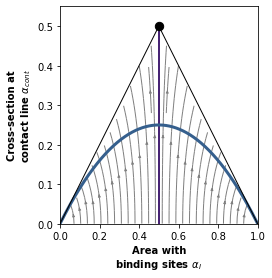

In [153]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharex=True)
plot_flow(ax, 0, kappa = 20, C0 = 0)
ax.scatter(0.5, 0.5, marker='o', c='black', s=70, zorder=3)
ax.set_ylim([0, 0.55])

ax.set_ylabel(r"Rescaled line tension $\zeta'$", fontweight='bold')

plt.savefig('figures/flow_C0_0.svg', dpi=300, bbox_inches='tight')

C:\Users\lenovo\AppData\Local\Temp/ipykernel_4764/3715213418.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.sqrt((1 - ((2 * A_cont)/A_I - 1)**2)/A_cont)/2
C:\Users\lenovo\AppData\Local\Temp/ipykernel_4764/3715213418.py:2: RuntimeWarning: invalid value encountered in divide
  return np.sqrt((1 - ((2 * A_cont)/A_I - 1)**2)/A_cont)/2
C:\Users\lenovo\AppData\Local\Temp/ipykernel_4764/3715213418.py:2: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((1 - ((2 * A_cont)/A_I - 1)**2)/A_cont)/2
C:\Users\lenovo\AppData\Local\Temp/ipykernel_4764/3715213418.py:5: RuntimeWarning: invalid value encountered in sqrt
  return - (A_I - 2 * A_cont)/(A_I**2 * np.sqrt(A_I - A_cont))/2
C:\Users\lenovo\AppData\Local\Temp/ipykernel_4764/3715213418.py:5: RuntimeWarning: divide by zero encountered in divide
  return - (A_I - 2 * A_cont)/(A_I**2 * np.sqrt(A_I - A_cont))/2
C:\Users\lenovo\AppData\Local\Temp/ipykernel_4764/3715213418.py:5: RuntimeWarning: invalid value enc

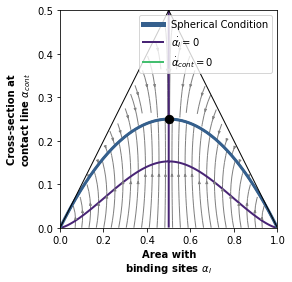

In [154]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharex=True)
plot_flow(ax, 0, kappa = 20, C0 = 1, legend = True)
ax.scatter(0.5, 0.25, marker='o', c='black', s=70, zorder=3)

ax.set_ylabel(r"Rescaled line tension $\zeta'$", fontweight='bold')

plt.savefig('figures/flow_C0_1.svg', dpi=300, bbox_inches='tight')